# Analysis of the Barcelona property market

The script visualizes the property market in Barcelona and identifies the good investment. The data is stored in './data/data.csv' and was obtained using the script 'Idealista API'.

*Author: Mislav Jordanić*

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import neighbors

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

df = pd.read_csv('./data/data.csv')

## Organize data

In [2]:
# Remove unnecesarry columns
df = df.drop(columns=['index', 'thumbnail', 'externalReference', 'numPhotos', 'province', 'country', 'showAddress', 'url', 'hasVideo', 'hasPlan', 'has3DTour', 'has360'])
df.propertyCode = df.propertyCode.astype(int)
df.reset_index(drop=True, inplace=True)
df.head(5)

propertyCode floor     price propertyType operation  size  exterior  rooms  \
0      87688139     3  172000.0         flat      sale  67.0     False      2   
1      89127122     2  130000.0         flat      sale  32.0      True      1   
2      89115559     1  149000.0         flat      sale  45.0     False      2   
3      89102591     5  220000.0         flat      sale  54.0      True      2   
4      89123676    bj  103000.0         flat      sale  67.0     False      2   

   bathrooms                    address municipality      district  \
0          2     Calle de Provença, 127    Barcelona      Eixample   
1          1            barrio El Raval    Barcelona  Ciutat Vella   
2          1    Calle d'Arnau d'Oms, 44    Barcelona    Nou Barris   
3          1  barrio La Sagrada Família    Barcelona      Eixample   
4          1        Calle de Travau, 29    Barcelona    Nou Barris   

                        neighborhood   latitude  longitude  distance  \
0    L'Antiga Esquerra de l'Eixample  41.387739   2.151873      1154   
1                           El Raval  41.380189   2.165333       880   
2                              Porta  41.430582   2.177449      4824   
3                 La Sagrada Família  41.410451   2.178700      2711   
4  Can Peguera - El Turó de la Peira  41.432788   2.169198      4977   

   newDevelopment  priceByArea          detailedType  \
0           False       2567.0  {'typology': 'flat'}   
1           False       4063.0  {'typology': 'flat'}   
2           False       3311.0  {'typology': 'flat'}   
3           False       4074.0  {'typology': 'flat'}   
4           False       1537.0  {'typology': 'flat'}   

                                      suggestedTexts status hasLift  \
0  {'subtitle': "L'Antiga Esquerra de l'Eixample,...    NaN     NaN   
1  {'subtitle': 'El Raval, Barcelona', 'title': '...   good   False   
2  {'subtitle': 'Porta, Barcelona', 'title': "Pis...   good    True   
3  {'subtitle': 'La Sagrada Família, Barcelona', ...   good    True   
4  {'subtitle': 'Can Peguera - El Turó de la Peir...  renew    True   

  parkingSpace newDevelopmentFinished  Week topNewDevelopment  
0          NaN                    NaN    14               NaN  
1          NaN                    NaN    14               NaN  
2          NaN                    NaN    14               NaN  
3          NaN                    NaN    14               NaN  
4          NaN                    NaN    14               NaN

In [3]:
df.describe()

propertyCode          price           size        rooms    bathrooms  \
count  4.646000e+03    4646.000000    4646.000000  4646.000000  4646.000000   
mean   8.889137e+07  237630.244511      98.270254     2.601378     1.211365   
std    3.674744e+06   88278.756997    1686.237923     0.917214     0.423334   
min    7.938120e+05   12900.000000      11.000000     0.000000     0.000000   
25%    8.914626e+07  168000.000000      60.000000     2.000000     1.000000   
50%    8.925351e+07  225500.000000      72.000000     3.000000     1.000000   
75%    8.935979e+07  310000.000000      85.000000     3.000000     1.000000   
max    8.949457e+07  400000.000000  115000.000000     6.000000     3.000000   

          latitude    longitude     distance   priceByArea         Week  
count  4646.000000  4646.000000  4646.000000   4646.000000  4646.000000  
mean     41.394651     2.159724  3447.163797   3297.261085    18.242789  
std       0.023714     0.031183  1615.476181   1112.048694     2.294850  
min      41.348364     2.083150   144.000000      1.000000    14.000000  
25%      41.373704     2.135954  2045.250000   2500.000000    16.000000  
50%      41.389976     2.166261  3476.000000   3215.000000    19.000000  
75%      41.415108     2.182126  4725.750000   3933.000000    20.000000  
max      41.449543     2.227291  6990.000000  20818.000000    21.000000

In [4]:
# Remove propertise with surface area bigger than 150m2 or price higher than 6000 euros/m2
df=df.loc[df['size'] < 150]
df = df[df['priceByArea'] < 6000]
df.reset_index(drop=True, inplace=True)

In [5]:
# Show basic info of each column and number of NaNs

print('Info')
print(df.info())

print('\n\nNull Elements')
print(df.isnull().sum())

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4529 entries, 0 to 4528
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   propertyCode            4529 non-null   int64  
 1   floor                   4161 non-null   object 
 2   price                   4529 non-null   float64
 3   propertyType            4529 non-null   object 
 4   operation               4529 non-null   object 
 5   size                    4529 non-null   float64
 6   exterior                4529 non-null   bool   
 7   rooms                   4529 non-null   int64  
 8   bathrooms               4529 non-null   int64  
 9   address                 4529 non-null   object 
 10  municipality            4529 non-null   object 
 11  district                4436 non-null   object 
 12  neighborhood            4430 non-null   object 
 13  latitude                4529 non-null   float64
 14  longitude               4529 non-nu

## Impute missing district and neighborhood
Impute missing district and neighborhood based on kNN and geolocation (latitude, longitude)

In [6]:
print('\n\n There are '+ repr(df.district.isnull().sum()) +' Null Elements in district to be imputed.')

index_missing = df.index[df.district.isnull()]

X = df.dropna(subset=['district']).loc[:,['latitude', 'longitude']]
y= df.dropna(subset =['district']).loc[:,'district']
assert X.shape[0]==y.shape[0], 'Dimensions do not match!'
model = neighbors.KNeighborsClassifier(2, weights='distance')
## Evaluate a knn model on the dataset using k-fold cross validation
# kfold = KFold(n_splits=3, random_state=7)
# result = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
# print(result.mean())
model.fit(X,y)
df.loc[index_missing, 'district'] = model.predict(X=df.loc[index_missing,['latitude', 'longitude']])



 There are 93 Null Elements in district to be imputed.


In [7]:
print('\n\n There are '+ repr(df.neighborhood.isnull().sum()) +' Null Elements in neighborhood to be imputed.')

index_missing = df.index[df.neighborhood.isnull()]

X = df.dropna(subset=['neighborhood']).loc[:,['latitude', 'longitude']]
y= df.dropna(subset =['neighborhood']).loc[:,'district']
assert X.shape[0]==y.shape[0], 'Dimensions do not match!'
model = neighbors.KNeighborsClassifier(2, weights='distance')
## evaluate a knn model on the dataset using k-fold cross validation
# kfold = KFold(n_splits=3, random_state=7)
# result = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
# print(result.mean())
model.fit(X,y)
df.loc[index_missing, 'neighborhood'] = model.predict(X=df.loc[index_missing,['latitude', 'longitude']])



 There are 99 Null Elements in neighborhood to be imputed.


## Analyze property types

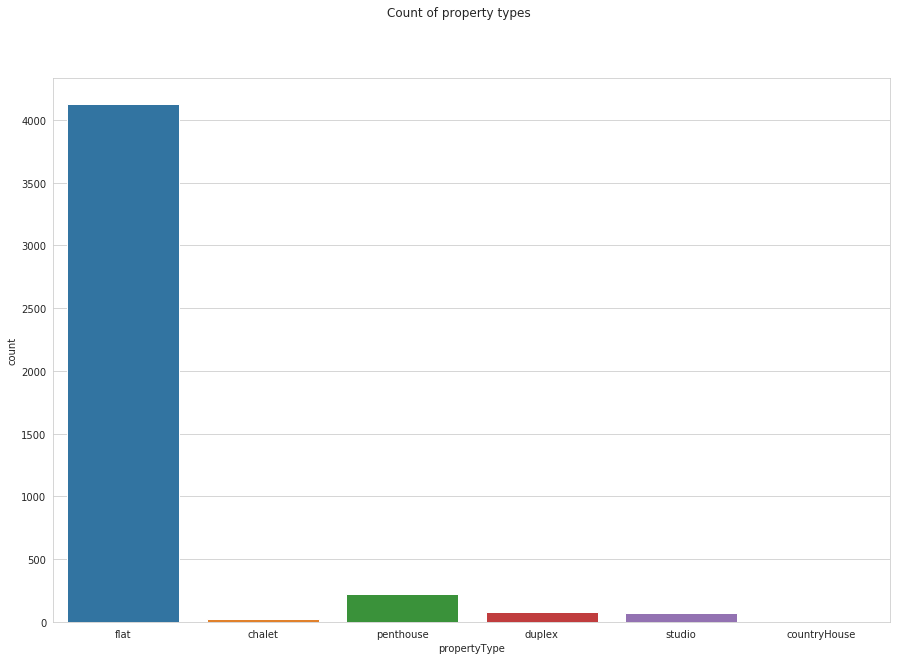

In [8]:
fig_size = (15,10)
fig, ax = plt.subplots(1,figsize=fig_size)
sns.countplot(x="propertyType", data=df, ax=ax);
fig.suptitle('Count of property types');

### Check distribution of Price, Size, and Price by Area

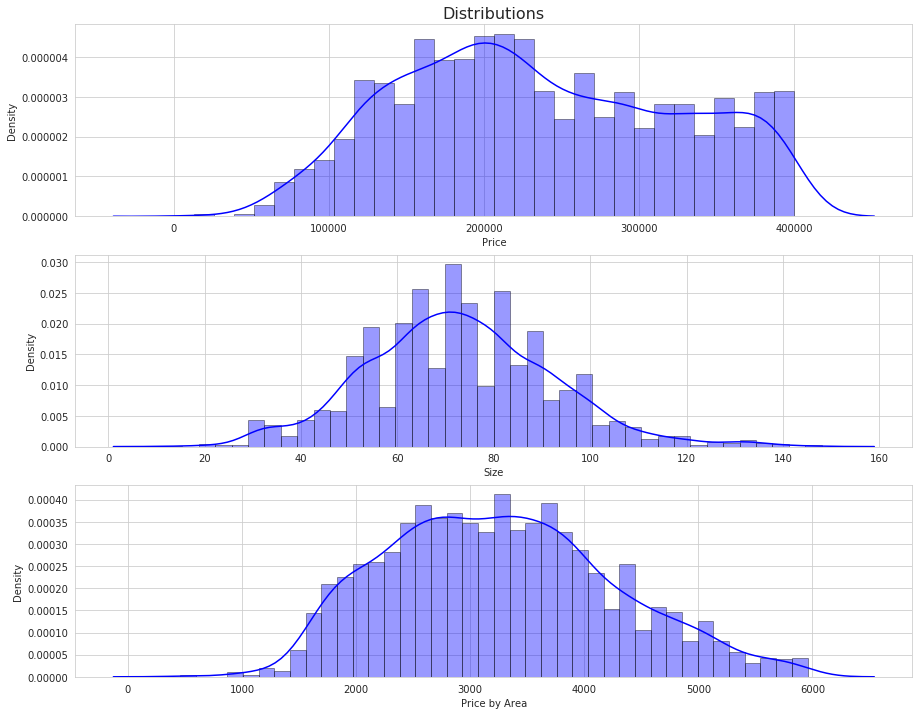

In [9]:
# Prices over 400k are exluded when requesting info from Idealista
fig_size = (15,12)
fig, ax = plt.subplots(3,figsize=fig_size)

sns.distplot(df['price'], hist=True, kde=True, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[0])
ax[0].set_title('Distributions', fontsize=16);
ax[0].set_xlabel('Price');
ax[0].set_ylabel('Density');


sns.distplot(df['size'], hist=True, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[1])
ax[1].set_xlabel('Size');
ax[1].set_ylabel('Density');


sns.distplot(df['priceByArea'], hist=True, kde=True, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[2])
ax[2].set_xlabel('Price by Area');
ax[2].set_ylabel('Density');


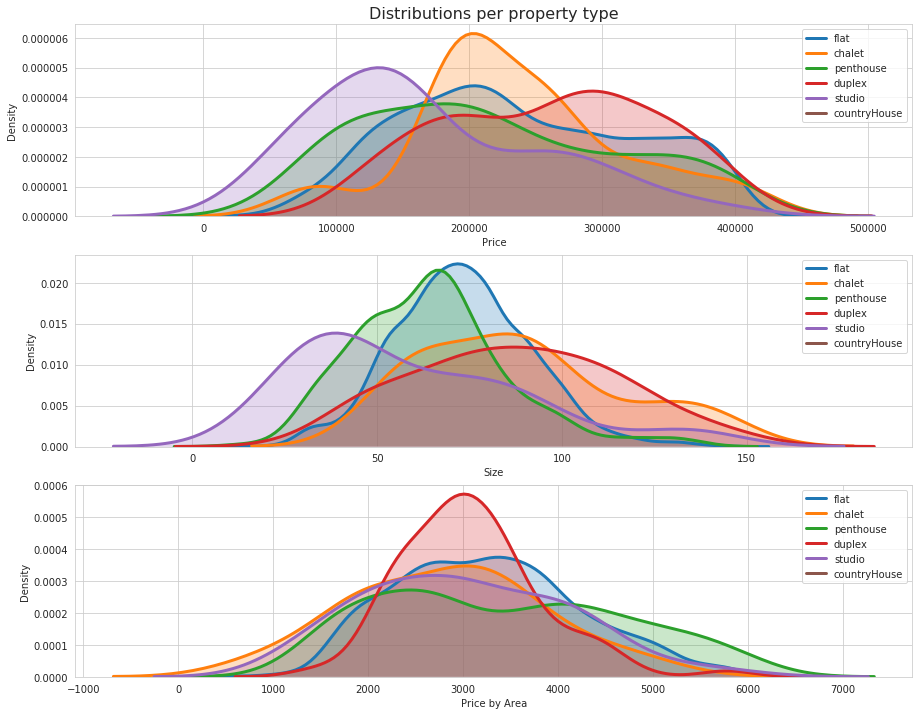

In [10]:
# Check for each type of property

fig_size = (15,12)
fig, ax = plt.subplots(3,figsize=fig_size)

for typeOfProperty in df.propertyType.unique():
    dfDist = df.loc[df['propertyType']==typeOfProperty, ['price', 'size', 'priceByArea']]
    
    sns.distplot(dfDist['price'], hist=False, kde=True, 
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[0])
    
    sns.distplot(dfDist['size'], hist=False, kde=True,
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[1])
    
    sns.distplot(dfDist['priceByArea'], hist=False, kde=True, 
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[2])
    
# Add labels
ax[0].set_title('Distributions per property type', fontsize=16);
ax[0].set_xlabel('Price');
ax[0].set_ylabel('Density');

ax[1].set_xlabel('Size');
ax[1].set_ylabel('Density');

ax[2].set_xlabel('Price by Area');
ax[2].set_ylabel('Density');
    
    

### Scatter plot of Price by Area vs. Size for each property type

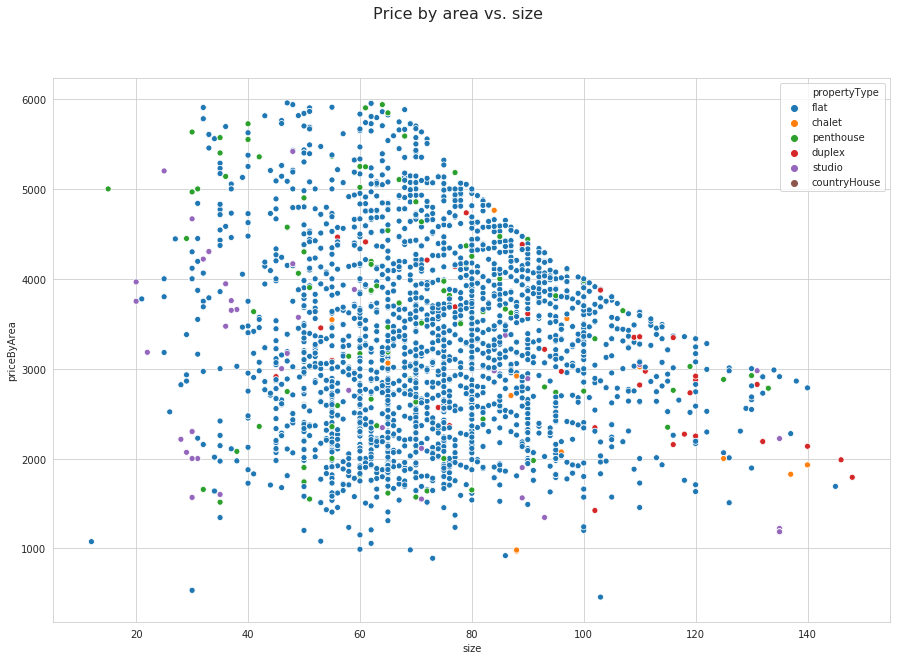

In [11]:
fig_size = (15,10)
fig, ax = plt.subplots(figsize=fig_size)
sns.scatterplot(y='priceByArea', x='size', hue='propertyType', data=df, ax=ax)
fig.suptitle('Price by area vs. size', fontsize=16);


### Number of rooms

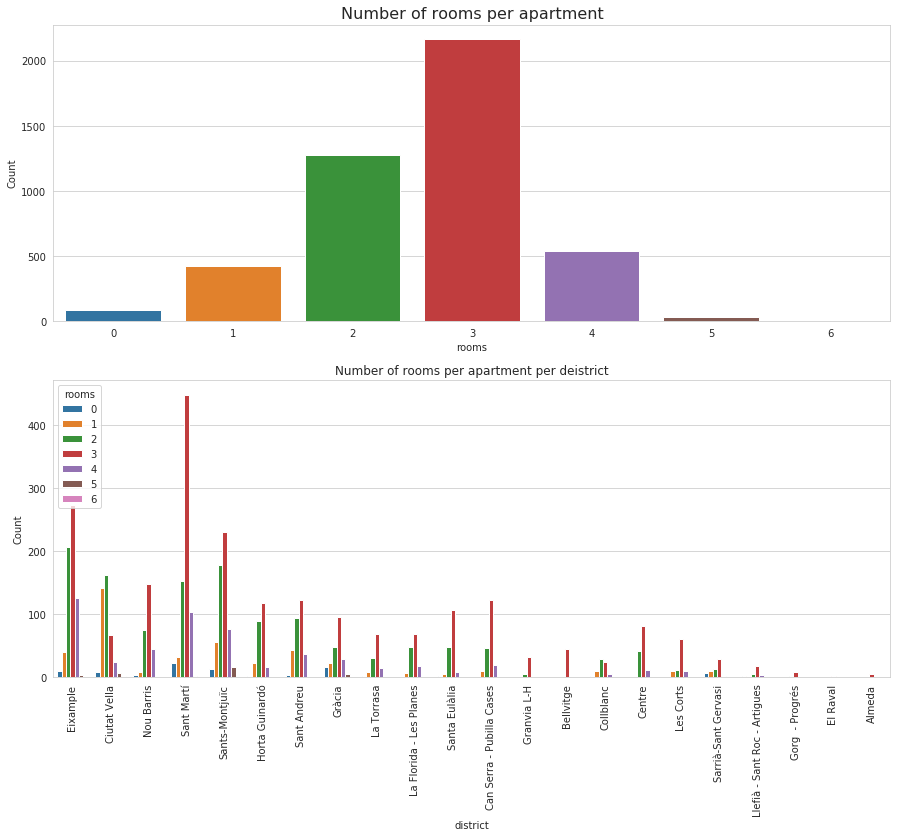

In [12]:
sns.set_style("whitegrid")
fig_size = (15,12)
fig, ax = plt.subplots(2, figsize=fig_size)

sns.countplot(x='rooms', orient = 0, data = df, ax = ax[0])
ax[0].set_title('Number of rooms per apartment', fontsize=16);
ax[0].set_ylabel('Count');

sns.countplot(x = 'district', hue = 'rooms', orient = 0, data = df, ax = ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90);
ax[1].set_title('Number of rooms per apartment per deistrict');
ax[1].set_ylabel('Count');


## Analyze the relationship of floor and price

### Clean floors
Clean floors and create new numerical column 'floorSort' with floor values

In [13]:
df['floor'] = df['floor'].astype(str)
df['floorSort'] = df['floor']
df['floorSort'].replace('en', str(0), inplace= True) # entreplanta = 0
df['floorSort'].replace('bj', str(-1), inplace= True) # bajo = -1
df['floorSort'].replace('ss', str(-1), inplace= True) # semisotano = -1
df['floorSort'].replace('st', str(-1), inplace= True) # semisotano = -1
df['floorSort'].replace('nan', str(-2), inplace= True) # nan = -2
df['floorSort'].replace('Unknown', str(-1), inplace= True) # Set unknown to -2

df.floorSort = df.floorSort.apply(pd.to_numeric)

# 'st' and 'ss' are bothsemisotano
df['floor'].replace('st', 'ss', inplace= True) 

# Show property type 'Penthouse' as floor
df.loc[df['propertyType'] == 'penthouse', 'floor'] =  'Penthouse'# Set unknown to -2
df.loc[df['propertyType'] == 'penthouse', 'floorSort'] =  df.floorSort.max() + 1# Set unknown to -2


### Counts and price distribution per floor

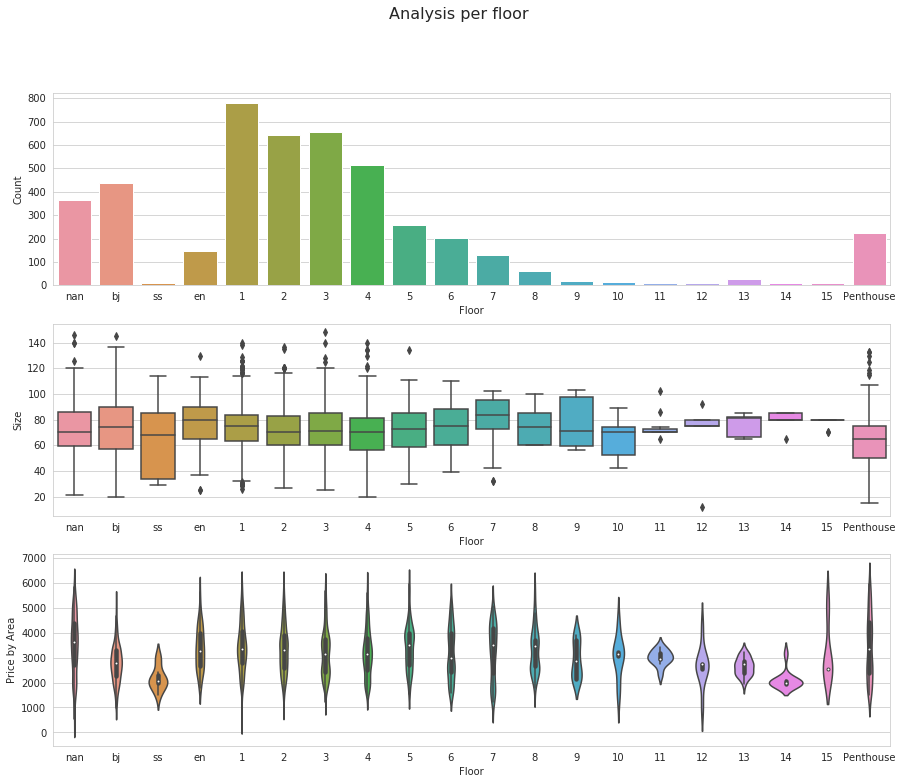

In [14]:
fig_size = (15,12)
fig, ax = plt.subplots(3, figsize=fig_size)
fig.suptitle('Analysis per floor', fontsize=16)
sns.countplot(x='floor', data=df.sort_values(by=['floorSort']), orient = 'v', ax=ax[0])
ax[0].set_xlabel('Floor');
ax[0].set_ylabel('Count');

sns.boxplot(x='floor', y='size', data=df.sort_values(by=['floorSort']), ax = ax[1])
ax[1].set_xlabel('Floor');
ax[1].set_ylabel('Size');

sns.violinplot(x='floor', y='priceByArea', data=df.sort_values(by=['floorSort']), ax = ax[2])
ax[2].set_xlabel('Floor');
ax[2].set_ylabel('Price by Area');


### Analyze number of penthouses per district

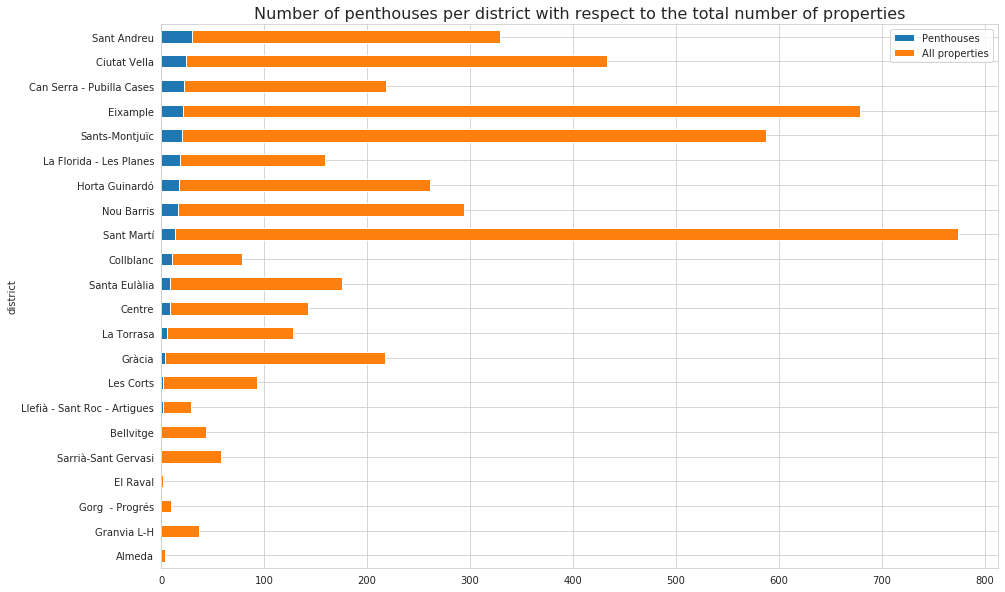

In [15]:
def get_penthouse(x):
    return x.loc[x == 'penthouse'].count()


def get_all(x):
    return x.count()


fig, ax = plt.subplots(1, figsize=(15, 10))


aux = df[['district', 'propertyType']].groupby(['district']).agg(
    [get_penthouse, get_all])
aux.columns = ['Penthouses', 'All properties']
aux.sort_values(by='Penthouses').plot.barh(stacked=True, ax=ax)
ax.set_title(
    'Number of penthouses per district with respect to the total number of properties', 
    fontsize=16);

## Location

### Plot properties to the map
Plot properties and penthouses with respect to price by area and size.

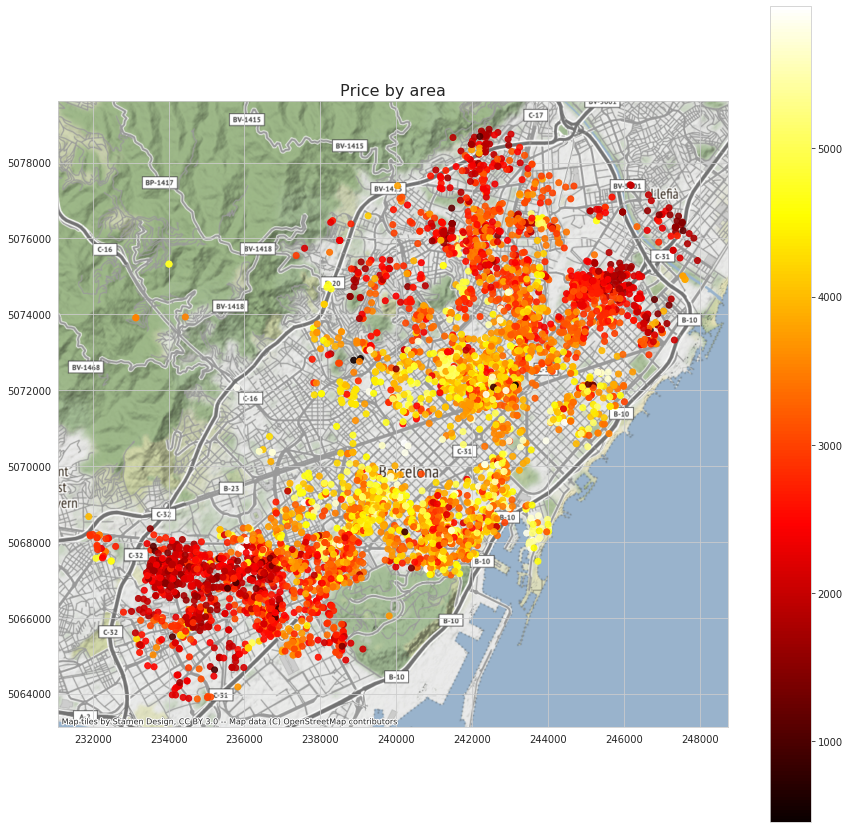

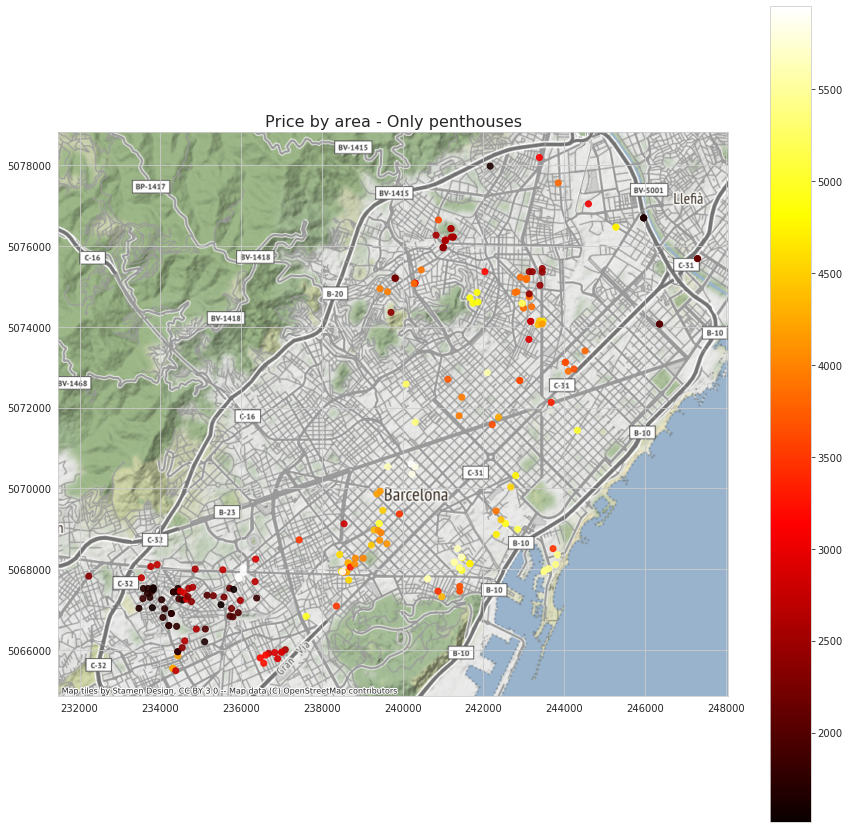

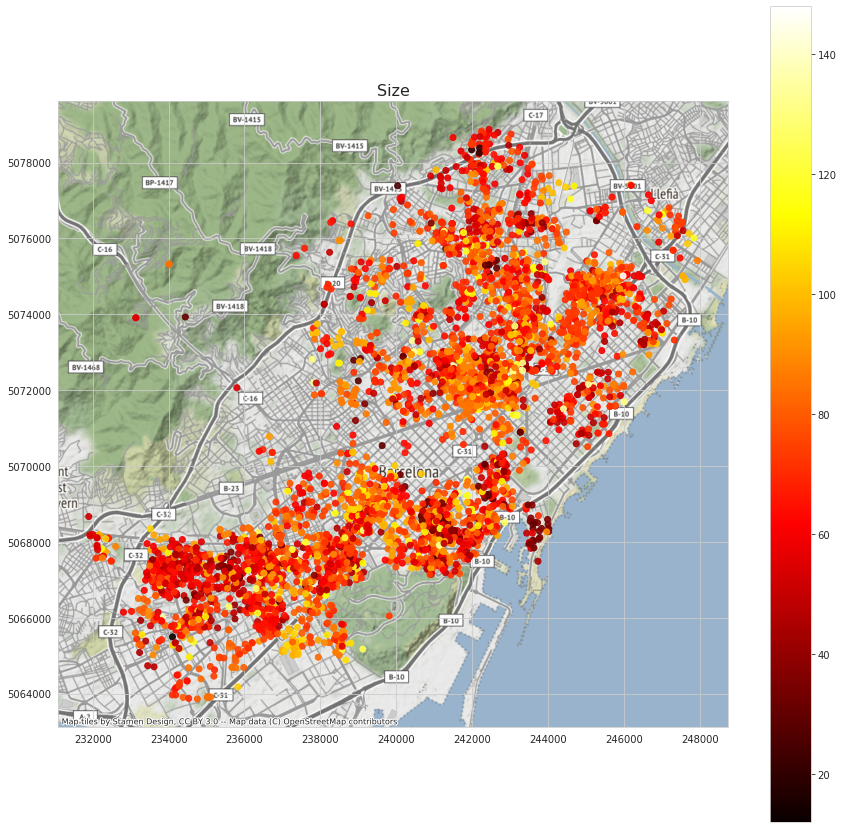

In [16]:
import geopandas as gpd
import descartes
import contextily as ctx


gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

figsize = (15,15)
fig, ax = plt.subplots(1, figsize=figsize)
gdf.plot(column='priceByArea', cmap='hot',  legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Price by area", fontsize=16);

fig, ax = plt.subplots(1, figsize=figsize)
gdf.loc[gdf['propertyType'] == 'penthouse'].plot(
    column='priceByArea', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Price by area - Only penthouses", fontsize=16);

fig, ax = plt.subplots(1, figsize=figsize)
gdf.plot(column='size', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Size", fontsize=16);

### Analyze prices per district

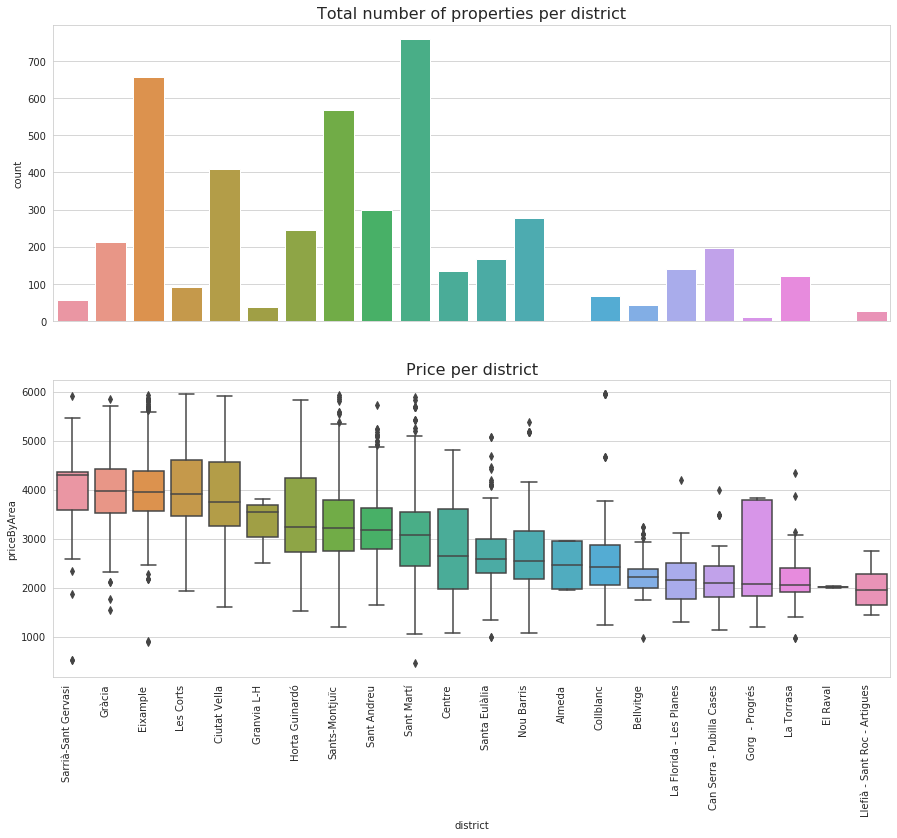

In [17]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)

sns.countplot(x='district', data=df,
              order=df.groupby('district')['priceByArea'].median().sort_values(ascending=False).index, orient='v', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_xlabel(None)
ax[0].set_title(
    'Total number of properties per district', fontsize=16);

sns.boxplot(y='priceByArea', x='district', data=df, ax=ax[1],
            order=df.groupby('district')['priceByArea'].median().sort_values(ascending=False).index)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right')
ax[1].set_title(
    'Price per district', fontsize=16);

### Change in price over time
Check the fluctuations per week

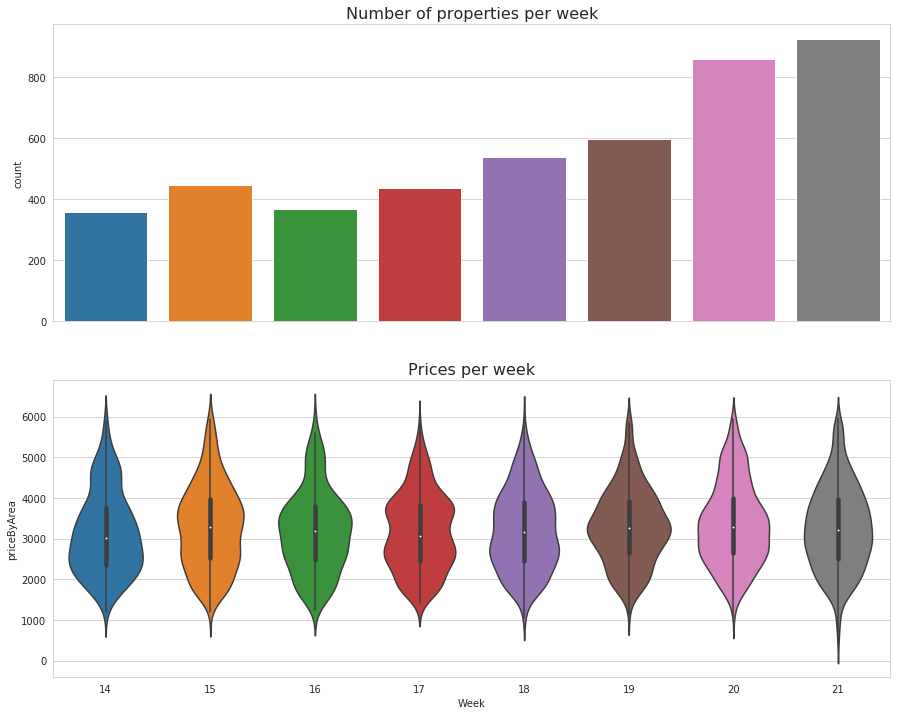

In [18]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)

sns.countplot(x='Week', data=df, ax=ax[0])
ax[0].set_xticks([])
ax[0].set_xlabel(None)
ax[0].set_title(
    'Number of properties per week', fontsize=16);

sns.violinplot(x='Week', y='priceByArea', data=df, ax=ax[1])
ax[1].set_title(
    'Prices per week', fontsize=16);

# Analysis of newly built apartments

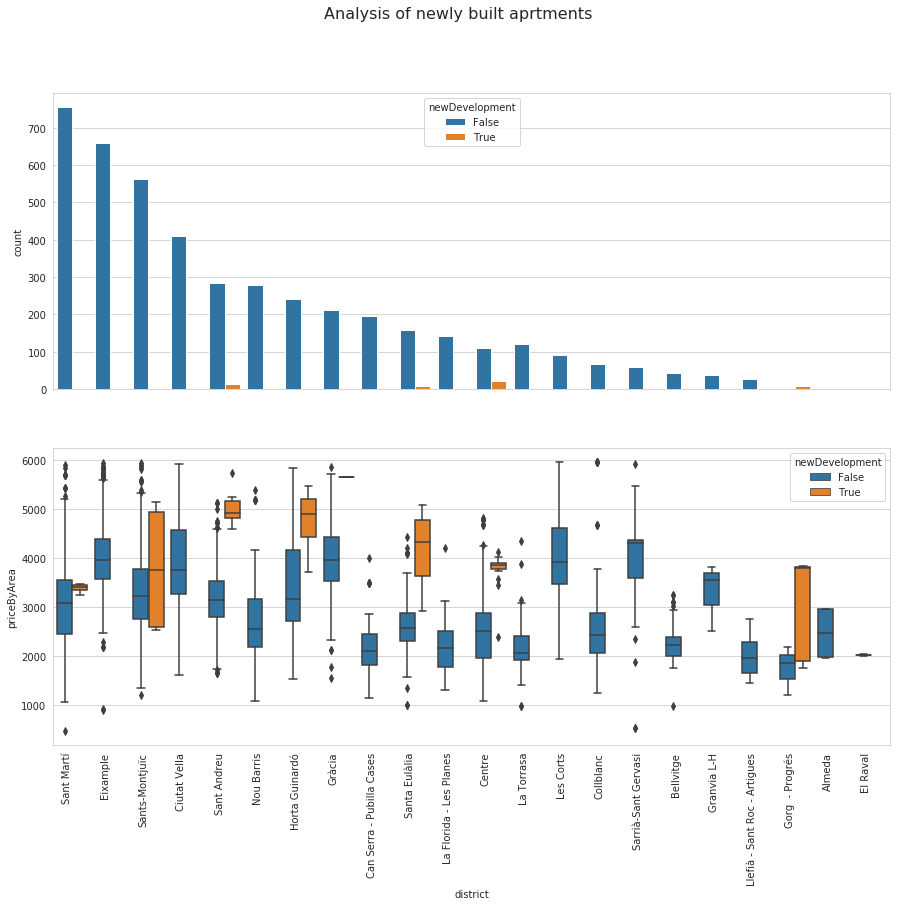

In [19]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='newDevelopment', data=df, ax=ax[0],
             order=df.groupby('district')['newDevelopment'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);

sns.boxplot(x='district', y='priceByArea', hue='newDevelopment',data=df,ax=ax[1],
           order=df.groupby('district')['newDevelopment'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Analysis of newly built aprtments', fontsize=16);

## Analysis of elevator
Check if the elevator has an effect on the price

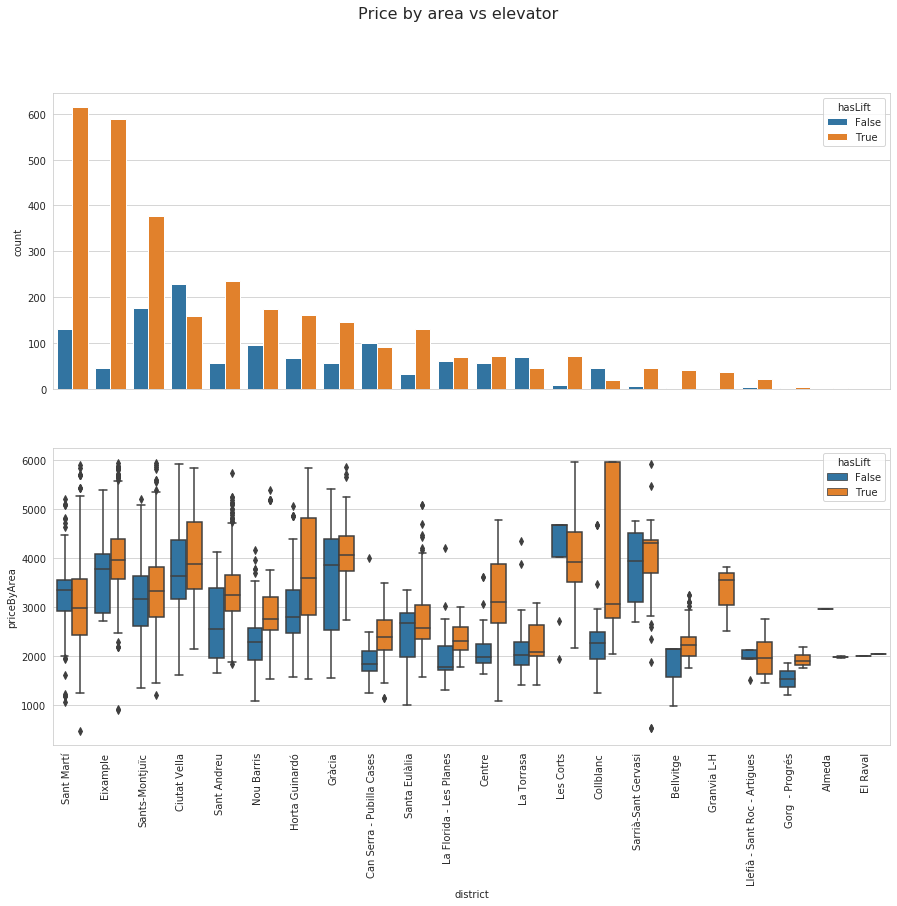

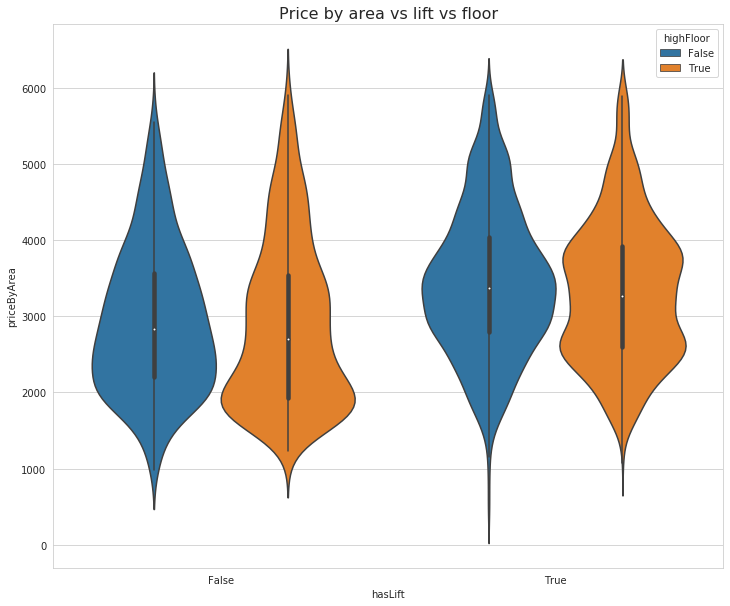

In [20]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='hasLift', data=df, ax=ax[0],
             order=df.groupby('district')['hasLift'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);

sns.boxplot(x='district', y='priceByArea', hue='hasLift', data=df,ax=ax[1],
           order=df.groupby('district')['hasLift'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Price by area vs elevator', fontsize=16);


# Compare price by area depending on the floor and the lift
fig_size = (12, 10)
fig, ax = plt.subplots(1, figsize=fig_size)
aux=df
aux['highFloor']=False
aux.loc[aux['floorSort']>2, 'highFloor'] = True
sns.violinplot(x='hasLift', y='priceByArea', hue='highFloor', data=aux,ax=ax);
ax.set_title('Price by area vs lift vs floor', fontsize=16);


## Exterior/interior
Check  the effect of interior/exterior property on the price

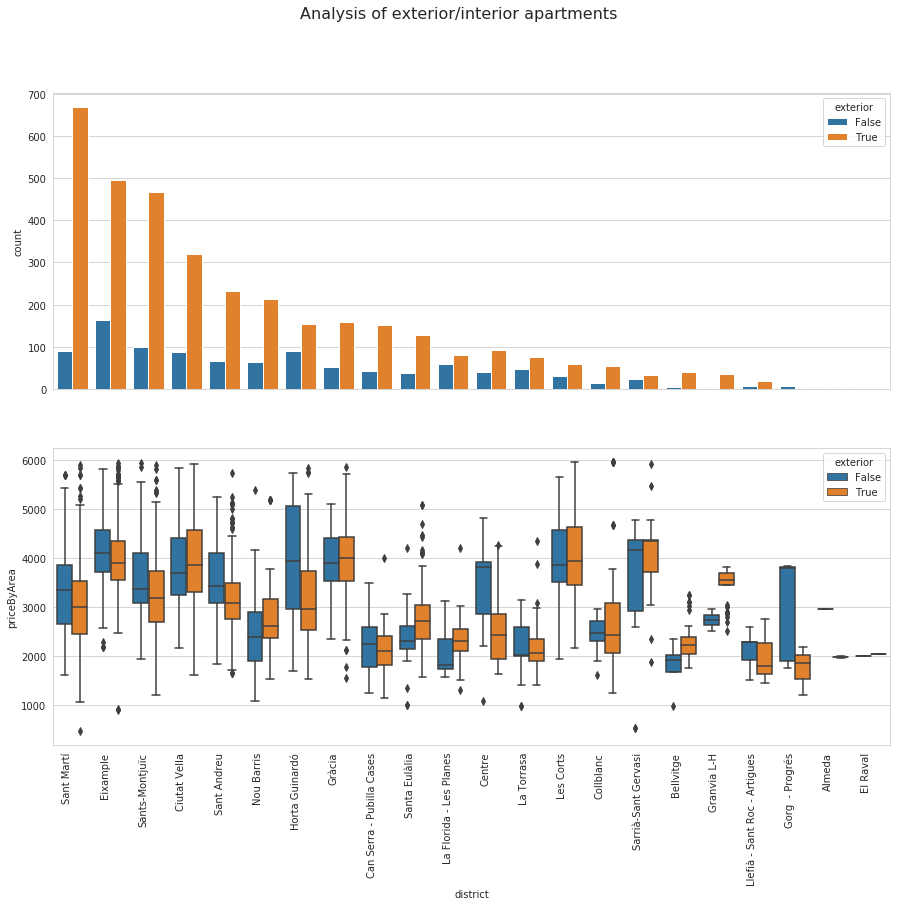

In [21]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='exterior', data=df, ax=ax[0],
             order=df.groupby('district')['exterior'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);

sns.boxplot(x='district', y='priceByArea', hue='exterior',data=df,ax=ax[1],
           order=df.groupby('district')['exterior'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Analysis of exterior/interior apartments', fontsize=16);

# Price Prediction
Using regression a price for each property is predicted. The properties with a significantly lower price than the predicted value are identified as a good investment oportunity.

### Organize and clean the data

In [22]:
# Print the names of the columns
for i in df.columns:
    print (i, end=', ')
    
df_model = df.drop(['highFloor','geometry', 'price', 'parkingSpace', 'Week', 'newDevelopmentFinished',
               'topNewDevelopment','status','suggestedTexts','detailedType','distance','neighborhood',
              'district','municipality','address','operation','propertyCode','floor'],axis=1)


propertyCode, floor, price, propertyType, operation, size, exterior, rooms, bathrooms, address, municipality, district, neighborhood, latitude, longitude, distance, newDevelopment, priceByArea, detailedType, suggestedTexts, status, hasLift, parkingSpace, newDevelopmentFinished, Week, topNewDevelopment, floorSort, geometry, highFloor, 

In [23]:
def clean_modelling_data(df):
    data = df
    # drop NaNs
    numberOfNans = data.isnull().sum().sum()/data.shape[0]
    assert numberOfNans<0.05, "Oh no! The number of NaNs is " + str(numberOfNans)
    data = data.dropna().reset_index(drop=True)
    data['hasLift'] = data['hasLift'].astype('bool')

    # get 0/1 for bool varibales
    data['exterior'] = data['exterior'].astype(int)
    data['newDevelopment'] = data['newDevelopment'].astype(int)
    data['hasLift'] = data['hasLift'].astype(int)

    # get dummies for categorical variables
    data = pd.get_dummies(data)
    return data

df_model = clean_modelling_data(df_model)

### Linear Regression
Simple linear regression model and the performance

The mean squared error (MSE) on train set: 716632.3648
The mean squared error (MSE) on test set: 773015.4936

The R square (R2) on train set: 0.2582
The R square (R2) on test set: 0.2329


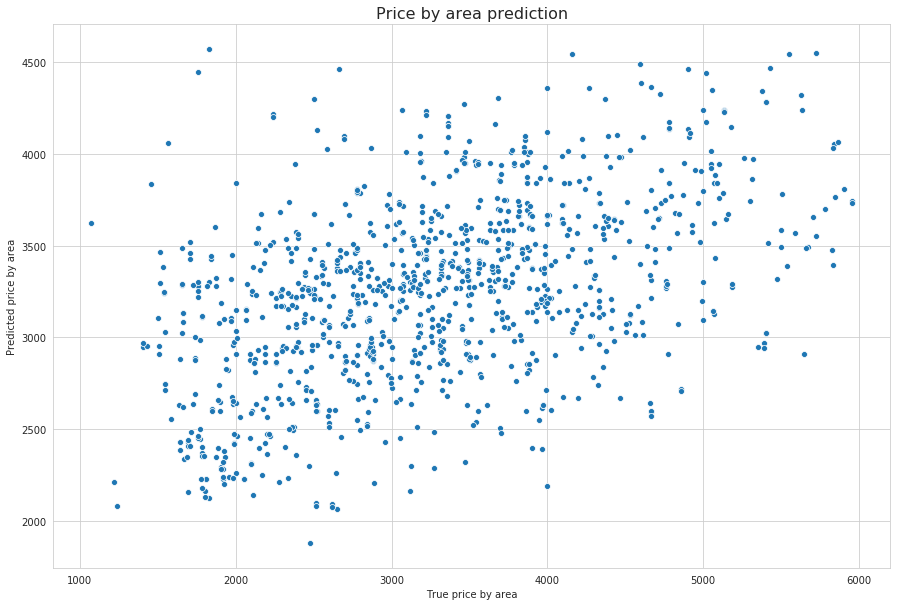

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

reg = LinearRegression()

labels = df_model['priceByArea']
train1 = df_model.drop(['priceByArea'],axis=1)
x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.25,random_state =2)

reg.fit(x_train,y_train)
reg.score(x_test,y_test)

mse_train = mean_squared_error(y_train, reg.predict(x_train))
mse_test = mean_squared_error(y_test, reg.predict(x_test))
R2_train = reg.score(x_train,y_train)
R2_test = reg.score(x_test,y_test)
print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_test))
print("\nThe R square (R2) on train set: {:.4f}".format(R2_train))
print("The R square (R2) on test set: {:.4f}".format(R2_test))
fig,ax= plt.subplots(1,figsize=(15, 10))
sns.scatterplot(x=y_test, y=reg.predict(x_test));
ax.set_ylabel('Predicted price by area');
ax.set_xlabel('True price by area');
ax.set_title('Price by area prediction', fontsize=16);

#plt.scatter(y_test, reg.predict(x_test),  color='black');

#### Improve the linear regression using ensemble learner
Improve the linear regression using Gradient Boosting Regressor

The mean squared error (MSE) on train set: 828.2226
The mean squared error (MSE) on test set: 221274.8702

The R square (R2) on train set: 0.9991
The R square (R2) on test set: 0.7804


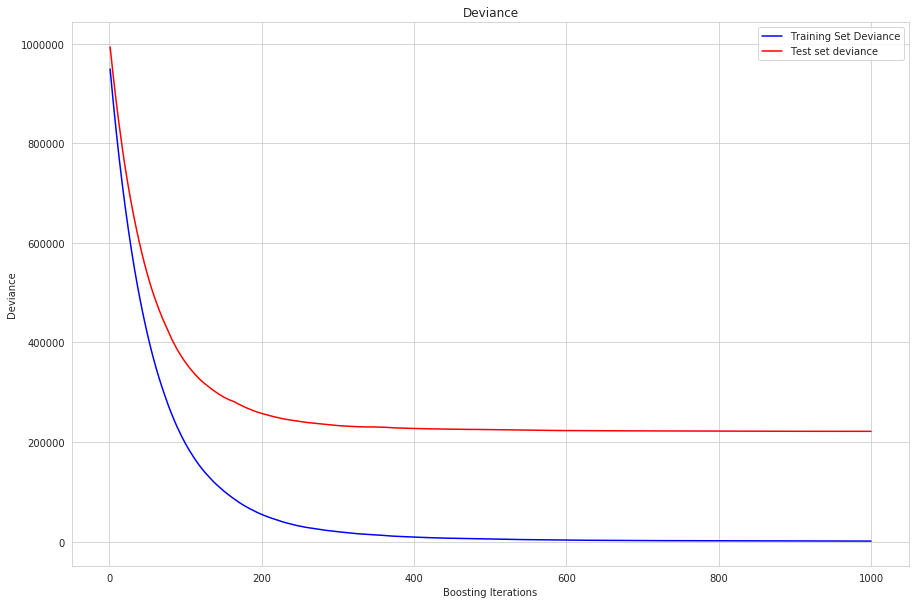

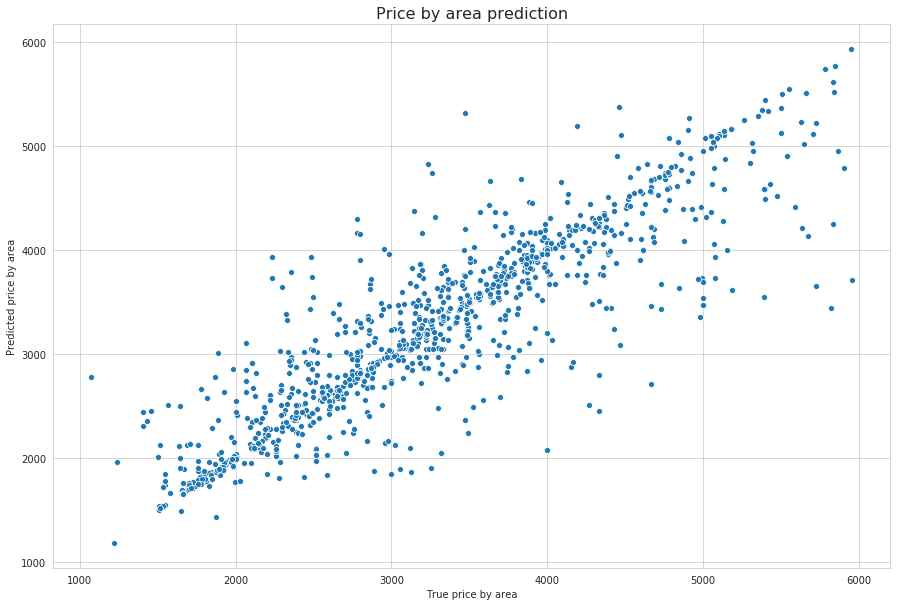

In [25]:
params = {'n_estimators': 1000,
          'max_depth': 12,
          'min_samples_split': 2,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

mse_train = mean_squared_error(y_train, reg.predict(x_train))
mse_test = mean_squared_error(y_test, reg.predict(x_test))
R2_train = reg.score(x_train,y_train)
R2_test = reg.score(x_test,y_test)
print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_test))
print("\nThe R square (R2) on train set: {:.4f}".format(R2_train))
print("The R square (R2) on test set: {:.4f}".format(R2_test))

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig,ax= plt.subplots(1,figsize=(15, 10))

plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
        label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test set deviance')
        
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.title('Deviance')

fig,ax= plt.subplots(1,figsize=(15, 10))
sns.scatterplot(x=y_test, y=reg.predict(x_test));
ax.set_ylabel('Predicted price by area');
ax.set_xlabel('True price by area');
ax.set_title('Price by area prediction', fontsize=16);


#### Perform Permutation Feature Importance analysis

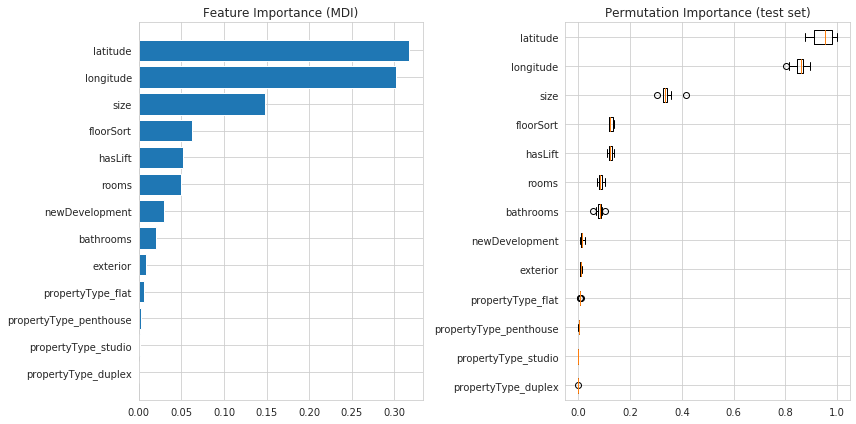

In [26]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(train1.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(train1.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()

### Identify the best offers in terms of Price by Area

#### Train the model on all samples

The mean squared error (MSE) on train set: 9409.7338
The R square (R2) on train set: 0.9904


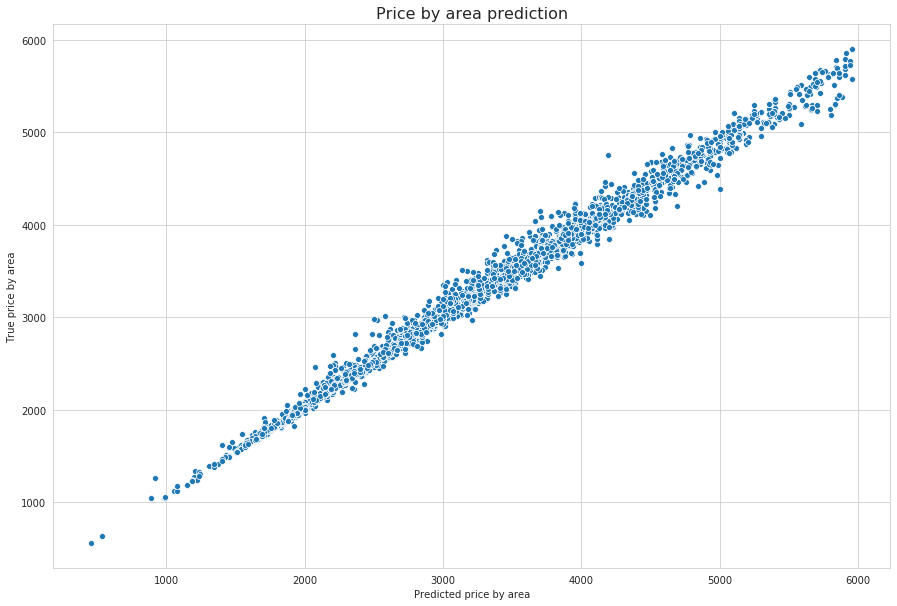

In [27]:
df_model = df.drop(['highFloor', 'geometry', 'price', 'parkingSpace', 'Week', 'newDevelopmentFinished',
                    'topNewDevelopment', 'status', 'suggestedTexts', 'detailedType', 'distance', 'neighborhood',
                    'district', 'municipality', 'address', 'operation', 'propertyCode', 'floor'], axis=1)

df_model = clean_modelling_data(df_model)

# Drop unnecessary features
df_model = df_model.drop(['propertyType_studio', 'propertyType_duplex'],axis=1)

params = {'n_estimators': 400,
          'max_depth': 12,
          'min_samples_split': 2,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(df_model.drop(['priceByArea'], axis=1), df_model['priceByArea'])

mse_train = mean_squared_error(df_model['priceByArea'], reg.predict(
    df_model.drop(['priceByArea'], axis=1)))
R2_train = reg.score(df_model.drop(
    ['priceByArea'], axis=1), df_model['priceByArea'])
print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
print("The R square (R2) on train set: {:.4f}".format(R2_train))

fig, ax = plt.subplots(1, figsize=(15, 10))
sns.scatterplot(df_model['priceByArea'], reg.predict(
    df_model.drop(['priceByArea'], axis=1)))
ax.set_ylabel('True price by area');
ax.set_xlabel('Predicted price by area');
ax.set_title('Price by area prediction', fontsize=16);

#### Create new columns in df with predicted price, price difference, and savings

In [28]:
df_model['predictedPrice'] = reg.predict(df_model.drop(['priceByArea'],axis=1))
# Price difference = PredictedPrice- priceByArea ==> the higher numbers are better investment
df_model['priceDifference'] = df_model['predictedPrice']-df_model['priceByArea']

df=df.join(df_model[['predictedPrice', 'priceDifference']])
df['savings'] = df['size']*df['priceDifference']

Show only the properties cheaper more than 'threshold' than predicted price (e.g. 10 000 euros).

In [29]:
# show only the properties cheaper by threashold from predicted price 
saving_threashold = 10000
df=df.loc[df['savings'] > saving_threashold]

df.sort_values(by='savings',ascending=False).head(50)

propertyCode      floor     price propertyType operation   size  \
897       89192555          1  330000.0         flat      sale   67.0   
2241      89292514          3  305000.0         flat      sale   92.0   
3733      89450509  Penthouse  340000.0    penthouse      sale   80.0   
4335      89409965         en  348000.0         flat      sale   90.0   
1042      89202544          7  157000.0         flat      sale  100.0   
1923      89255671          3  290000.0         flat      sale  110.0   
1824      88554373          2  219000.0         flat      sale   65.0   
3506      89368602          6  205000.0         flat      sale  104.0   
988       89196819         13  224000.0         flat      sale   82.0   
3642      89109343          4  185000.0         flat      sale   60.0   
96        89107753  Penthouse  119000.0    penthouse      sale   65.0   
4037      89460353          8  315000.0         flat      sale   85.0   
692       89150196          3  122000.0         flat      sale   61.0   
2893      89369925  Penthouse  270000.0    penthouse      sale  115.0   
3920      89492803         bj  160000.0       studio      sale  135.0   
2391      89296596          7  250000.0         flat      sale   72.0   
682       89137143          1  365000.0         flat      sale  106.0   
2715      89292837          5  275000.0         flat      sale   86.0   
3436      89331596          3  338000.0         flat      sale  110.0   
793       89131566          2  390000.0         flat      sale   85.0   
2828      89382554          3  239000.0         flat      sale   67.0   
1905      89263071          1  248000.0         flat      sale   80.0   
2873      88854458         bj  285000.0         flat      sale  108.0   
3072      89370668          4  219000.0         flat      sale   76.0   
2148      89296616          5  320000.0         flat      sale   81.0   
3746      89431721          5  386000.0         flat      sale   78.0   
461       89128918          3  328000.0         flat      sale   87.0   
3380      89357142        nan  260000.0         flat      sale   79.0   
1496      89219555        nan  310000.0         flat      sale   75.0   
3787      88962685          2  219000.0         flat      sale   63.0   
2646      89276670        nan  175000.0         flat      sale   82.0   
3718      89447582          7   95000.0         flat      sale   77.0   
3087      89379032          4  280000.0       duplex      sale   76.0   
2766      88556333          1  199000.0         flat      sale   78.0   
3544      89324720         bj  260000.0         flat      sale  120.0   
1296      38798950          3  380000.0         flat      sale   71.0   
3489      89338135          4   98000.0         flat      sale   45.0   
2680      88637237          3  225000.0         flat      sale   70.0   
2064      89253208          4  340000.0         flat      sale   69.0   
2068      89258394          2  220000.0         flat      sale   60.0   
3678      87277385          5  249000.0         flat      sale   82.0   
1797      89266669          7  189000.0         flat      sale   71.0   
2347      89290978         bj  350000.0         flat      sale  105.0   
4191      88924042          2  210000.0         flat      sale   57.0   
878       89197518          4  219000.0         flat      sale   76.0   
3266      89327667          4  400000.0         flat      sale  103.0   
594       89137282          7  166000.0         flat      sale  100.0   
3427      89357052          4  315000.0         flat      sale   95.0   
1996      89264347          3  138000.0         flat      sale   50.0   
3396      89330103          1  295000.0         flat      sale  103.0   

      exterior  rooms  bathrooms                                 address  \
897      False      2          1                        Calle de Còrsega   
2241      True      3          1  barrio El Poble Sec - Parc de Montjuïc   
3733      True      3          2                    ba

#### Plot the properties on the map

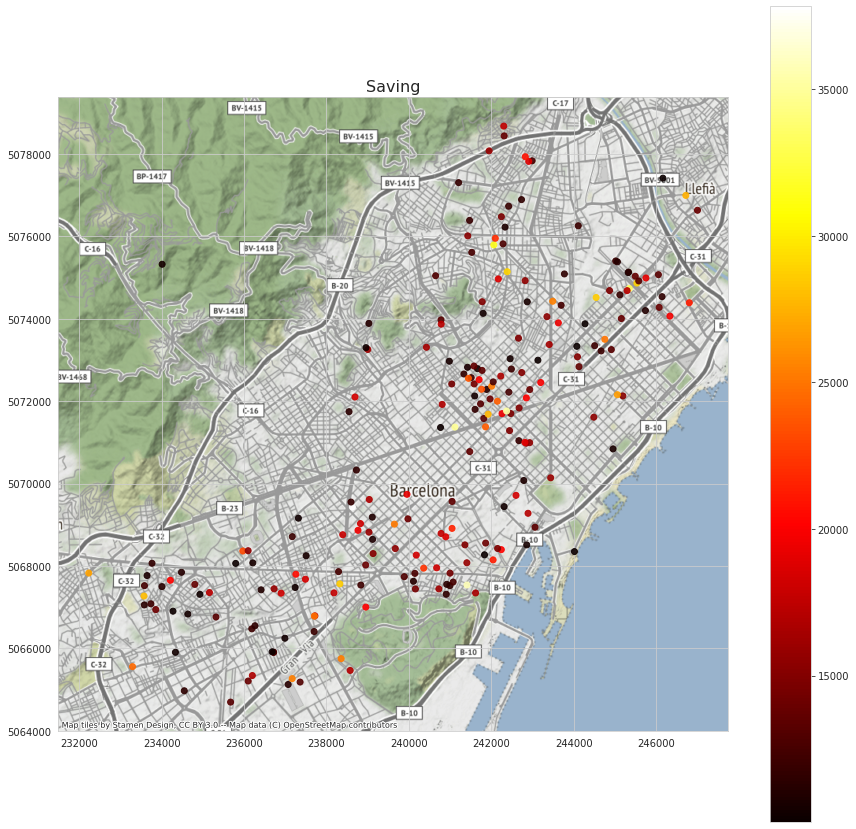

In [30]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

figsize = (15, 15)
fig, ax = plt.subplots(1, figsize=figsize)
propertyTypeDict = {'flat': 'o', 'penthouse': 'd',
                    'studio': 's', 'duplex': '^', 'chalet': '<'}

gdf.plot(column='savings', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Saving", fontsize=16);

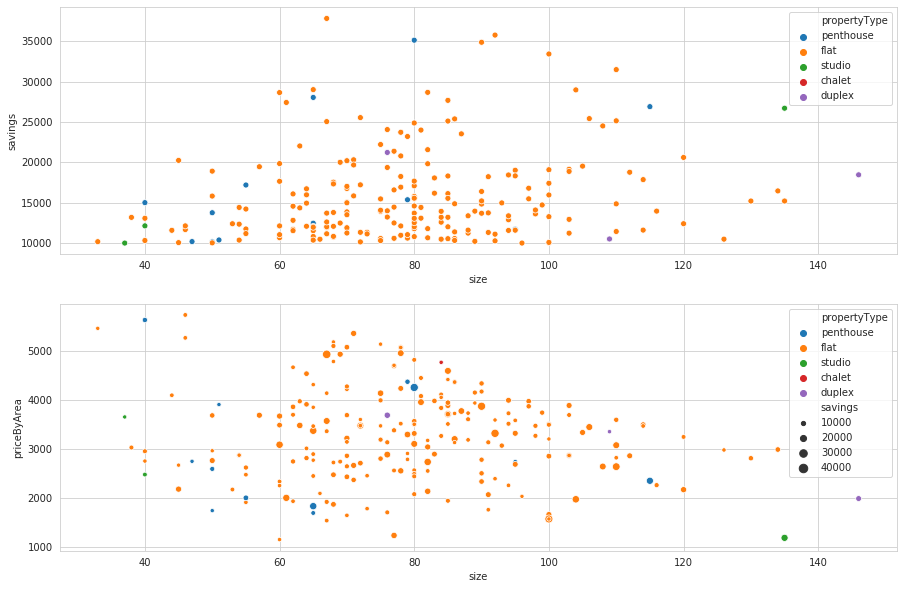

In [31]:
fig,ax= plt.subplots(2,figsize=(15, 10))
sns.scatterplot(x='size', y='savings', hue= 'propertyType', data=df,ax=ax[0]);
#sns.scatterplot(x='size', y='priceByArea', hue= 'savings', data=df,ax=ax[1]);
sns.scatterplot(x='size', y='priceByArea', size= 'savings', hue='propertyType', data=df,ax=ax[1]);

#### Get the identifier of the selected property

In [32]:
df.loc[(df['size'] > 70) & (df['size'] < 100) & (
    df['propertyType'] == 'penthouse')].sort_values(by='savings', ascending=False)

propertyCode      floor     price propertyType operation  size  \
3733      89450509  Penthouse  340000.0    penthouse      sale  80.0   
3271      89358955  Penthouse  345000.0    penthouse      sale  79.0   
3193      89333259  Penthouse  260000.0    penthouse      sale  95.0   

      exterior  rooms  bathrooms                address  \
3733      True      3          2   barrio El Fort Pienc   
3271      True      2          2     Calle d'Espronceda   
3193      True      3          1  JACINTO BENAVENTE s/n   

                municipality                   district  \
3733               Barcelona                   Eixample   
3271               Barcelona                Sant Andreu   
3193  Esplugues de Llobregat  Can Serra - Pubilla Cases   

                   neighborhood   latitude  longitude  distance  \
3733              El Fort Pienc  41.401611   2.177274      1785   
3271                      Navas  41.417044   2.186065      3639   
3193  Can Serra - Pubilla Cases  41.376702   2.099946      5630   

      newDevelopment  priceByArea  \
3733           False       4250.0   
3271           False       4367.0   
3193           False       2737.0   

                                          detailedType  \
3733  {'typology': 'flat', 'subTypology': 'penthouse'}   
3271  {'typology': 'flat', 'subTypology': 'penthouse'}   
3193  {'typology': 'flat', 'subTypology': 'penthouse'}   

                                         suggestedTexts status hasLift  \
3733  {'subtitle': 'El Fort Pienc, Barcelona', 'titl...   good    True   
3271  {'subtitle': 'Navas, Barcelona', 'title': "Áti...   good    True   
3193  {'subtitle': 'Esplugues de Llobregat', 'title'...   good    True   

     parkingSpace newDevelopmentFinished  Week topNewDevelopment  floorSort  \
3733          NaN                    NaN    21             False         16   
3271          NaN                    NaN    20             False         16   
3193          NaN                    NaN    20             False         16   

                      geometry  highFloor  predictedPrice  priceDifference  \
3733  POINT (2.17727 41.40161)       True     3018.095620       439.095620   
3271  POINT (2.18607 41.41704)       True     3178.642221       194.642221   
3193  POINT (2.09995 41.37670)       True     1956.416167       123.416167   

           savings  
3733  35127.649589  
3271  15376.735462  
3193  11724.535852